# Transformation Equations:  DES DR2 <--> SDSS DR13

_Douglas L. Tucker_

_2020.11.18_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [2]:
# Order of polynomial fits...
norder = 2

# Color to fit against...
color_name_1 = 'gi_sdss'

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# Identify directory containing the DES/SDSS match file...
matchDir = '.'

# Name of the DES/SDSS match file in matchDir
matchFile = 'match_y6a2_stripe82area_stars_SDSSDR13.fits'

# Identify directory containing the fits results file...
resultsDir = 'default'

# Name of the fit results output file...
resultsFile = 'default'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [3]:
##################################
#
# Define some functions for fitting dmag vs. color...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp1, we assume a polynomial function in one color...
def fp1(p,color1_array):
    #retValue = p[0] + p[1]*color1_array + p[2]*color1_array*color1_array
    norder = p.size-1
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
    return retValue


##################################

# Error function:
def residuals1(p,color1_array,dmag_array):
    err = (dmag_array-fp1(p,color1_array))
    return err


##################################

# Fitting code:
def transformFit1(color1_array, dmag_array, norder=2, verbose=0):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2'])
    pname = []
    for i in range(0,norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0]
    p0 = (1+norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals1, p0, 
                                      args=(color1_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0:  print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:  
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:  
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms


##################################
#
# Define some functions for fitting dmag vs. color1 and color2...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp2, we assume a polynomial in each of the 2 colors 
#   but with no cross terms... 
def fp2(p,color1_array,color2_array):
    #retValue = p[0] + \
    #    p[1]*color1_array + p[2]*color1_array*color1_array + \
    #    p[3]*color2_array + p[4]*color2_array*color2_array
    norder = (p.size-1)/2
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
        retValue = retValue + p[i+norder+1]*color2_array**(i+1)
    return retValue


##################################

# Error function:
def residuals2(p,color1_array,color2_array,dmag_array):
    err = (dmag_array-fp2(p,color1_array,color2_array))
    return err


##################################

# Fitting code:
def transformFit2(color1_array, color2_array, dmag_array, norder=2, verbose=0):
    
    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2', 'c_3', 'c_4'])
    pname = []
    for i in range(0,2*norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0, 0.0, 0.0]
    p0 = (1+2*norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0


    # Perform fit
    p,cov,infodict,mesg,ier = leastsq(residuals2, p0, 
                                      args=(color1_array, color2_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0: print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms



In [4]:
##################################

def createFitResultsOutputLine(norder, p, perr, rms, dmag_name, color1_name, color2_name=''):

    outputList = (2*(2*norder+1)+4)*[-9999.]
    outputList[0] = dmag_name
    outputList[1] = color1_name
    outputList[2] = color2_name
    for j in range(p.size):
        outputList[2*j+3] = p[j]
        outputList[2*j+4] = perr[j]
    outputList[2*(2*norder+1)+3] = rms
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine(norder):

    outputList = (2*(2*norder+1)+4)*['c_']
    outputList[0] = 'dmag_name'
    outputList[1] = 'color1_name'
    outputList[2] = 'color2_name'
    for j in range(2*norder+1):
        outputList[2*j+3] = ("""c_%d""" % j)
        outputList[2*j+4] = ("""cerr_%d""" % j)
    outputList[2*(2*norder+1)+3] = 'rms'
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def transform1ColorQAPlots1(dmag, color1, res, norder, dmagName, colorName1, p, rms, outputFileName):

    # Prepare QA plots...
    fig = plt.figure(figsize=(10,5))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")

    # We will exclude the lowest and highets 1% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.01, 0.99])
    dmag_desc = dmag.describe(percentiles=[0.01, 0.99])
    #res_desc = df.res.describe(percentiles=[0.01, 0.99])
    res_desc = res.describe(percentiles=[0.01, 0.99])
    color1_min = color1_desc['1%']
    color1_max = color1_desc['99%']
    dmag_min = dmag_desc['1%']
    dmag_max = dmag_desc['99%']
    res_min = res_desc['1%']
    res_max = res_desc['99%']

    # Plot 1:  Descriptive text...
    plt.subplot(231)
    if norder == 1:
        plot1Text = """%s = \n %.3f + \n %.3f*%s \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, rms)
    elif norder == 2:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName1, rms)
    else:
        plot1Text = ''
    plt.text(0.1,0.25,plot1Text)
    plt.axis('off')

    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(232) 
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorName1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 3:  N/A

    # Plot 4:  1d histogram of residuals...
    plt.subplot(234) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    # Plot 5:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(235) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorName1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot 6:  N/A

    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

def transform2ColorQAPlots1(dmag, color1, color2, res, norder, dmagName, colorName1, colorName2, p, rms, outputFileName):

    # Prepare QA plots...
    fig = plt.figure(figsize=(10,5))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")

    # We will exclude the lowest and highets 1% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.01, 0.99])
    color2_desc = color2.describe(percentiles=[0.01, 0.99])
    dmag_desc = dmag.describe(percentiles=[0.01, 0.99])
    #res_desc = df.res.describe(percentiles=[0.01, 0.99])
    res_desc = res.describe(percentiles=[0.01, 0.99])
    color1_min = color1_desc['1%']
    color1_max = color1_desc['99%']
    color2_min = color2_desc['1%']
    color2_max = color2_desc['99%']
    dmag_min = dmag_desc['1%']
    dmag_max = dmag_desc['99%']
    res_min = res_desc['1%']
    res_max = res_desc['99%']

    # Plot 1:  Descriptive text...
    plt.subplot(231)
    if norder == 1:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName2, rms)
    elif norder == 2:
        plot1Text = """%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName1, p[3], colorName2, p[4], colorName2, rms)
    else:
        plot1Text = ''
    plt.text(0.1,0.25,plot1Text)
    plt.axis('off')

    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(232) 
    hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorName1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 3:  2D hexbin histogram of dmag vs. color2...
    plt.subplot(233) 
    hb=plt.hexbin(color2, dmag, gridsize=100, cmap='inferno')
    plt.axis([color2_min, color2_max, dmag_min, dmag_max])
    plt.xlabel(colorName2)
    plt.ylabel(dmagName)
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(color='white')
    plt.grid(True)

    # Plot 4:  1d histogram of residuals...
    plt.subplot(234) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    # Plot 5:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(235) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorName1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot 6:  2d hexbin histogram of residuals vs. color2...
    plt.subplot(236) 
    #hb = plt.hexbin(color2, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color2, res, gridsize=100, cmap='inferno')
    plt.axis([color2_min, color2_max, res_min, res_max])
    plt.xlabel(colorName2)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    cb.set_label('Number')
    plt.grid(True)
    plt.grid(color='white')

    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################

# Based on plotly code at http://inversionlabs.com/2016/03/21/best-fit-surface.html
def transform2ColorQAPlots2(df, colName_dmag, colName_color1, colName_color2, colName_res, dmagName, colorName1, colorName2, norder, p, rms, outputFileName):

    # An initial sanity check...
    if norder > 2:
        print 'transform2ColorQAPlots2 can not deal with norder > 2...  skipping...'
        return 1

    # Create data from color1, color2, and dmag...
    #  If the sample size is larger than 1000, 
    #  take a random sample of 1000 elements...
    n_elements = df[colName_res].size
    if n_elements <= 1000:
        x = df.loc[:,colName_color1].values
        y = df.loc[:,colName_color2].values
        z = df.loc[:,colName_dmag].values
    else:
        df1000 = df.sample(n=1000,axis=0)
        n_elements = df1000[colName_res].size
        x = df1000.loc[:,colName_color1].values
        y = df1000.loc[:,colName_color2].values
        z = df1000.loc[:,colName_dmag].values    
    data = np.c_[x,y,z]

    
    # Regular grid covering the domain of the data...
    mn = np.min(data, axis=0)
    mx = np.max(data, axis=0)
    X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
    XX = X.flatten()
    YY = Y.flatten()
    
    # Evaluate it on grid...
    if norder == 1:
        Z = p[0] + p[1]*X + p[2]*Y
    elif norder == 2:
        Z = p[0] + p[1]*X + p[2]*X**2 + p[3]*Y + p[4]*Y**2        
    
    # Create data_fit from color1, color2, and the fit parameters p[*]...
    x_fit = x
    y_fit = y
    if norder == 1:
        z_fit = p[0] + p[1]*x_fit + p[2]*y_fit
    elif norder == 2:
        z_fit = p[0] + p[1]*x_fit + p[2]*x_fit*x_fit + p[3]*y_fit + p[4]*y_fit*y_fit
    data_fit = np.c_[x_fit,y_fit,z_fit]
    #delta_z = z - z_fit

    # trace1 is the scatter plot of the original points...
    trace1 = go.Scatter3d(
        x=data[:,0],
        y=data[:,1],
        z=data[:,2], 
        #z=delta_z, 
        mode='markers',
        marker=dict(size=1, color='red', line=dict(color='black', width=0.5), opacity=0.5)
        )

    # trace2 is the scatter plot of the fit values at the x,y positions of the original points...
    trace2 = go.Scatter3d(
        x=data_fit[:,0],
        y=data_fit[:,1],
        z=data_fit[:,2],
        mode='markers',
        marker=dict(size=2, color='yellow', line=dict(color='black', width=0.5), opacity=0.8)
        )

    # trace3 is the 2D surface of the fit equation...
    trace3 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.333)

    # Package the trace dictionaries into a data object
    data_go = go.Data([trace1, trace2, trace3])

    # Dictionary of style options for all axes
    axis = dict(
        showbackground=True, # show axis background
        backgroundcolor="rgb(204, 204, 204)", # set background color to grey
        gridcolor="rgb(255, 255, 255)",       # set grid line color
        zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
        )

    # Create a title...
    if norder == 1:
        titleText = """%s = %.3f + %.3f*%s + %.3f*%s [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName2, rms)
    elif norder == 2:
        titleText = """%s = %.3f + %.3f*%s + %.3f*%s^2 + %.3f*%s + %.3f*%s^2\n[npts=%d, rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName1, p[3], colorName2, p[4], colorName2, n_elements, rms)
    else:
        titleText = ''
    titleText = titleText.replace('$','')

    # Make a layout object
    layout = go.Layout(
        title=titleText, # set plot title
        scene=go.Scene(  # axes are part of a 'scene' in 3d plots
            xaxis=go.XAxis(axis), # set x-axis style
            yaxis=go.YAxis(axis), # set y-axis style
            zaxis=go.ZAxis(axis)),  # set z-axis style
        )


    # Make a figure object
    fig = go.Figure(data=data_go, layout=layout)

    # Create interactive plot and save as javascript to html file...
    #plotly.offline.iplot(fig, filename=outputFileName)
    plotly.offline.plot(fig, filename=outputFileName, auto_open=False)

    return 0


##################################

# Based on plotly code at http://inversionlabs.com/2016/03/21/best-fit-surface.html
def transform2ColorQAPlots3(df, colName_dmag, colName_color1, colName_color2, colName_res, dmagName, colorName1, colorName2, norder, p, rms, outputFileName):

    # An initial sanity check...
    if norder > 2:
        print 'transform2ColorQAPlots3 can not deal with norder > 2...  skipping...'
        return 1

    # Create data from color1, color2, and res...
    #  If the sample size is larger than 1000, 
    #  take a random sample of 1000 elements...
    n_elements = df[colName_res].size
    if n_elements <= 1000:
        x = df.loc[:,colName_color1].values
        y = df.loc[:,colName_color2].values
        z = df.loc[:,colName_res].values
    else:
        df1000 = df.sample(n=1000,axis=0)
        n_elements = df1000[colName_res].size
        x = df1000.loc[:,colName_color1].values
        y = df1000.loc[:,colName_color2].values
        z = df1000.loc[:,colName_res].values    
    data = np.c_[x,y,z]

    
    # Regular grid covering the domain of the data...
    mn = np.min(data, axis=0)
    mx = np.max(data, axis=0)
    X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
    XX = X.flatten()
    YY = Y.flatten()
    
    # Evaluate it on grid...
    Z = 0.00 + 0.00*X + 0.00*Y
    
    # Create data_fit from color1, color2, and the fit parameters p[*]...
    x_fit = x
    y_fit = y
    z_fit = 0.00 + 0.00*x_fit + 0.00*y_fit
    data_fit = np.c_[x_fit,y_fit,z_fit]

    # trace1 is the scatter plot of the original points...
    trace1 = go.Scatter3d(
        x=data[:,0],
        y=data[:,1],
        z=data[:,2], 
        mode='markers',
        marker=dict(size=1, color='red', line=dict(color='black', width=0.5), opacity=0.5)
        )

    # trace2 is the scatter plot of the fit values at the x,y positions of the original points...
    trace2 = go.Scatter3d(
        x=data_fit[:,0],
        y=data_fit[:,1],
        z=data_fit[:,2],
        mode='markers',
        marker=dict(size=2, color='yellow', line=dict(color='black', width=0.5), opacity=0.8)
        )

    # trace3 is the 2D surface of the fit equation...
    #trace3 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.667)
    trace3 = go.Surface(z=Z, x=X, y=Y, colorscale='Greys', opacity=0.667)

    # Package the trace dictionaries into a data object
    data_go = go.Data([trace1, trace2, trace3])

    # Dictionary of style options for all axes
    axis = dict(
        showbackground=True, # show axis background
        backgroundcolor="rgb(204, 204, 204)", # set background color to grey
        gridcolor="rgb(255, 255, 255)",       # set grid line color
        zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
        )

    # Create a title...
    if norder == 1:
        titleText = """%s = %.3f + %.3f*%s + %.3f*%s [rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName2, rms)
    elif norder == 2:
        titleText = """%s = %.3f + %.3f*%s + %.3f*%s^2 + %.3f*%s + %.3f*%s^2\n[npts=%d, rms: %.3f]""" % \
            (dmagName, p[0], p[1], colorName1, p[2], colorName1, p[3], colorName2, p[4], colorName2, n_elements, rms)
    else:
        titleText = ''
    titleText = titleText.replace('$','')

    # Make a layout object
    layout = go.Layout(
        title=titleText, # set plot title
        scene=go.Scene(  # axes are part of a 'scene' in 3d plots
            xaxis=go.XAxis(axis), # set x-axis style
            yaxis=go.YAxis(axis), # set y-axis style
            zaxis=go.ZAxis(axis)),  # set z-axis style
        )


    # Make a figure object
    fig = go.Figure(data=data_go, layout=layout)

    # Create interactive plot and save as javascript to html file...
    #plotly.offline.iplot(fig, filename=outputFileName)
    plotly.offline.plot(fig, filename=outputFileName, auto_open=False)

    return 0



## Read in Matched Catalog

In [5]:
matchFile = os.path.join(matchDir,matchFile)
print matchFile

./match_y6a2_stripe82area_stars_SDSSDR13.fits


In [6]:
# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """ERROR:  matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  ./match_y6a2_stripe82area_stars_SDSSDR13.fits


In [7]:
tab = Table.read(matchFile, format='fits')
tab

COADD_OBJECT_ID,RA_1,DEC_1,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,B,EBV_SFD98,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_J2000,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,XWIN_IMAGE,YWIN_IMAGE,MAG_DETMODEL_G,MAG_AUTO_G,MAG_APER_8_G,WAVG_MAG_PSF_G,MAGERR_DETMODEL_G,MAGERR_AUTO_G,MAGERR_APER_8_G,WAVG_MAGERR_PSF_G,FLUX_DETMODEL_G,FLUX_AUTO_G,WAVG_FLUX_PSF_G,FLUX_RADIUS_G,FLUX_APER_8_G,FLUXERR_DETMODEL_G,FLUXERR_AUTO_G,WAVG_FLUXERR_PSF_G,FLUXERR_APER_8_G,MU_EFF_MODEL_G,MU_MAX_G,MU_MAX_MODEL_G,MU_MEAN_MODEL_G,MU_THRESHOLD_G,SPREADERR_MODEL_G,SPREAD_MODEL_G,CLASS_STAR_G,NITER_MODEL_G,WAVG_SPREADERR_MODEL_G,WAVG_SPREAD_MODEL_G,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,MOLY_NUMBER_G,MAG_DETMODEL_R,MAG_AUTO_R,MAG_APER_8_R,WAVG_MAG_PSF_R,MAGERR_DETMODEL_R,MAGERR_AUTO_R,MAGERR_APER_8_R,WAVG_MAGERR_PSF_R,FLUX_DETMODEL_R,FLUX_AUTO_R,WAVG_FLUX_PSF_R,FLUX_RADIUS_R,FLUX_APER_8_R,FLUXERR_DETMODEL_R,FLUXERR_AUTO_R,WAVG_FLUXERR_PSF_R,FLUXERR_APER_8_R,MU_EFF_MODEL_R,MU_MAX_R,MU_MAX_MODEL_R,MU_MEAN_MODEL_R,MU_THRESHOLD_R,SPREADERR_MODEL_R,SPREAD_MODEL_R,CLASS_STAR_R,NITER_MODEL_R,WAVG_SPREADERR_MODEL_R,WAVG_SPREAD_MODEL_R,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,MOLY_NUMBER_R,MAG_DETMODEL_I,MAG_AUTO_I,MAG_APER_8_I,WAVG_MAG_PSF_I,MAGERR_DETMODEL_I,MAGERR_AUTO_I,MAGERR_APER_8_I,WAVG_MAGERR_PSF_I,FLUX_DETMODEL_I,FLUX_AUTO_I,WAVG_FLUX_PSF_I,FLUX_RADIUS_I,FLUX_APER_8_I,FLUXERR_DETMODEL_I,FLUXERR_AUTO_I,WAVG_FLUXERR_PSF_I,FLUXERR_APER_8_I,MU_EFF_MODEL_I,MU_MAX_I,MU_MAX_MODEL_I,MU_MEAN_MODEL_I,MU_THRESHOLD_I,SPREADERR_MODEL_I,SPREAD_MODEL_I,CLASS_STAR_I,NITER_MODEL_I,WAVG_SPREADERR_MODEL_I,WAVG_SPREAD_MODEL_I,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,MOLY_NUMBER_I,MAG_DETMODEL_Z,MAG_AUTO_Z,MAG_APER_8_Z,WAVG_MAG_PSF_Z,MAGERR_DETMODEL_Z,MAGERR_AUTO_Z,MAGERR_APER_8_Z,WAVG_MAGERR_PSF_Z,FLUX_DETMODEL_Z,FLUX_AUTO_Z,WAVG_FLUX_PSF_Z,FLUX_RADIUS_Z,FLUX_APER_8_Z,FLUXERR_DETMODEL_Z,FLUXERR_AUTO_Z,WAVG_FLUXERR_PSF_Z,FLUXERR_APER_8_Z,MU_EFF_MODEL_Z,MU_MAX_Z,MU_MAX_MODEL_Z,MU_MEAN_MODEL_Z,MU_THRESHOLD_Z,SPREADERR_MODEL_Z,SPREAD_MODEL_Z,CLASS_STAR_Z,NITER_MODEL_Z,WAVG_SPREADERR_MODEL_Z,WAVG_SPREAD_MODEL_Z,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,MOLY_NUMBER_Z,MAG_DETMODEL_Y,MAG_AUTO_Y,MAG_APER_8_Y,WAVG_MAG_PSF_Y,MAGERR_DETMODEL_Y,MAGERR_AUTO_Y,MAGERR_APER_8_Y,WAVG_MAGERR_PSF_Y,FLUX_DETMODEL_Y,FLUX_AUTO_Y,WAVG_FLUX_PSF_Y,FLUX_RADIUS_Y,FLUX_APER_8_Y,FLUXERR_DETMODEL_Y,FLUXERR_AUTO_Y,WAVG_FLUXERR_PSF_Y,FLUXERR_APER_8_Y,MU_EFF_MODEL_Y,MU_MAX_Y,MU_MAX_MODEL_Y,MU_MEAN_MODEL_Y,MU_THRESHOLD_Y,SPREADERR_MODEL_Y,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,rawrap,name,ra_2,dec_2,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,arcsec
int64,float64,float64,float64,float64,int64,int32,int32,str48,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,f

In [8]:
df = tab.to_pandas()
df

,COADD_OBJECT_ID,RA_1,DEC_1,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
0,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.352320,18.197308,0.105668,0.017967,0.016583,0.023540,0.027509,6361.0,1188.0,0.072306
1,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.273417,16.676876,0.189597,0.026167,0.015462,0.021712,0.017184,7778.0,83.0,0.131657
2,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,16.957182,16.818913,0.028147,0.018261,0.025981,0.018688,0.016255,7717.0,81.0,0.081412
3,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.321367,18.298330,0.039136,0.023591,0.014854,0.019058,0.027282,4263.0,82.0,0.147025
4,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.302778,16.103003,0.041825,0.020095,0.013199,0.018106,0.014031,2662.0,82.0,0.153573
5,1.034175e+09,0.000446,-4.093737,0.000446,-4.093737,2765741.0,54158.0,57212.0,DES0000-0416,92.631699,...,16.801933,16.655245,0.036887,0.025139,0.016387,0.013504,0.019310,6372.0,1188.0,0.167864
6,1.033052e+09,0.000603,2.368938,0.000603,2.368938,2763744.0,59148.0,63542.0,DES0000+0209,98.119377,...,18.253973,17.978533,0.194086,0.022775,0.022852,0.024477,0.028400,7712.0,81.0,0.101826
7,1.032398e+09,0.000712,-3.137557,0.000712,-3.137557,2764753.0,6582.0,6535.0,DES0000-0250,93.581673,...,16.352743,15.775401,0.155956,0.028578,0.017661,0.022097,0.017449,7907.0,83.0,0.166721
8,1.031851e+09,0.000722,-1.804559,0.000722,-1.804559,2758897.0,63615.0,68635.0,DES0000-0207,94.815483,...,17.041483,16.389420,0.193003,0.025014,0.022046,0.017063,0.015475,7778.0,83.0,0.254651
9,1.032029e+09,0.000793,3.106721,0.000793,3.106721,2763746.0,52903.0,57019.0,DES0000+0252,98.630432,...,17.687784,17.438276,0.096128,0.020033,0.014446,0.011822,0.017752,7717.0,81.0,0.093407


In [9]:
# Rename columns...
df.rename(columns={'RA_1':'RA_des',
                   'DEC_1':'DEC_des',
                   'ra_2':'RA_sdss',
                   'dec_2':'DEC_sdss',
                   'WAVG_MAG_PSF_G':'g_des',
                   'WAVG_MAG_PSF_R':'r_des',
                   'WAVG_MAG_PSF_I':'i_des',
                   'WAVG_MAG_PSF_Z':'z_des',
                   'WAVG_MAG_PSF_Y':'Y_des',
                   'WAVG_MAGERR_PSF_G':'g_err_des',
                   'WAVG_MAGERR_PSF_R':'r_err_des',
                   'WAVG_MAGERR_PSF_I':'i_err_des',
                   'WAVG_MAGERR_PSF_Z':'z_err_des',
                   'WAVG_MAGERR_PSF_Y':'Y_err_des',
                   'psfMag_u':'u_sdss',
                   'psfMag_g':'g_sdss',
                   'psfMag_r':'r_sdss',
                   'psfMag_i':'i_sdss',
                   'psfMag_z':'z_sdss',
                   'psfMagErr_u':'u_err_sdss',
                   'psfMagErr_g':'g_err_sdss',
                   'psfMagErr_r':'r_err_sdss',
                   'psfMagErr_i':'i_err_sdss',
                   'psfMagErr_z':'z_err_sdss',
                  },inplace=True)

df.head(5)

,COADD_OBJECT_ID,RA_des,DEC_des,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,i_sdss,z_sdss,u_err_sdss,g_err_sdss,r_err_sdss,i_err_sdss,z_err_sdss,run,stripe,Separation
0,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.352320,18.197308,0.105668,0.017967,0.016583,0.023540,0.027509,6361.0,1188.0,0.072306
1,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.273417,16.676876,0.189597,0.026167,0.015462,0.021712,0.017184,7778.0,83.0,0.131657
2,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,16.957182,16.818913,0.028147,0.018261,0.025981,0.018688,0.016255,7717.0,81.0,0.081412
3,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.321367,18.298330,0.039136,0.023591,0.014854,0.019058,0.027282,4263.0,82.0,0.147025
4,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.302778,16.103003,0.041825,0.020095,0.013199,0.018106,0.014031,2662.0,82.0,0.153573


## Add Columns to Matched Catalog Data Frame

In [10]:
# Add color columns...
df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']

In [11]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [12]:
mask = ( ( df[color_name_1] > -1. ) & ( df[color_name_1] < 4.0 ) )

## Make Backup Copies of Initial Mask and Original Data Frame

In [13]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

   iter1...

Initial parameter values:   [-0.049602508544921875, 0.0, 0.0]
Converged
Converged with chi squared  1821.29425944
degrees of freedom, dof  578390
RMS of residuals (i.e. sqrt(chisq/dof))  0.0561150909996
Reduced chisq (i.e. variance of residuals)  0.0031489034379

Fitted parameters at minimum, with 68% C.I.:
c_0            -0.002373 +/-   0.000273268   (11.515732 percent)
c_1           -0.0501015 +/-   0.000474597   (0.947271 percent)
c_2          -0.00304537 +/-   0.000170586   (5.601491 percent)

Correlation matrix:
                c_0        c_1        c_2       
c_0          1.000000
c_1         -0.935028   1.000000
c_2          0.842419  -0.965217   1.000000



   iter2...

Initial parameter values:   [-0.049425125122070312, 0.0, 0.0]
Converged
Converged with chi squared  380.166020093
degrees of freedom, dof  569113
RMS of residuals (i.e. sqrt(chisq/dof))  0.0258456462047
Reduced chisq (i.e. variance of residuals)  0.000667997427739

Fitted parameters at minimum, with

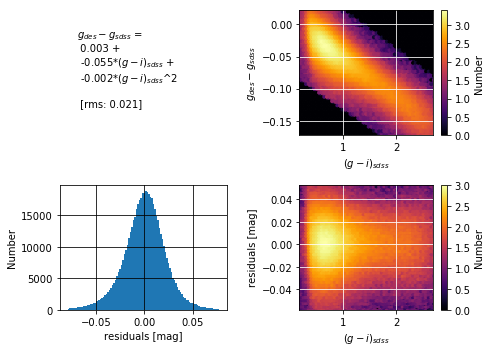

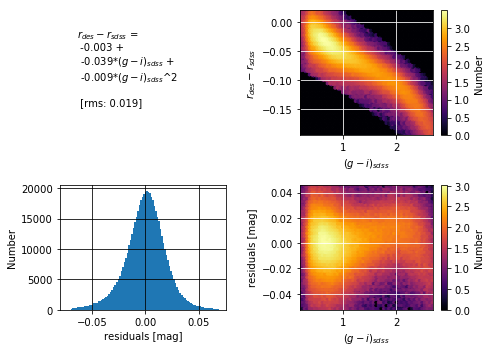

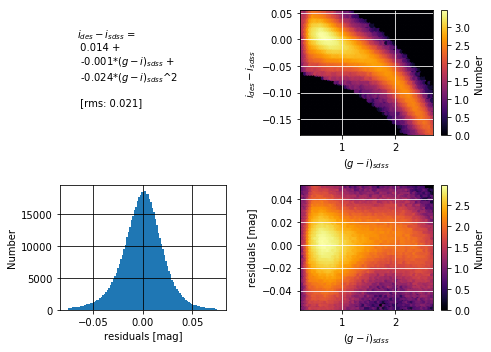

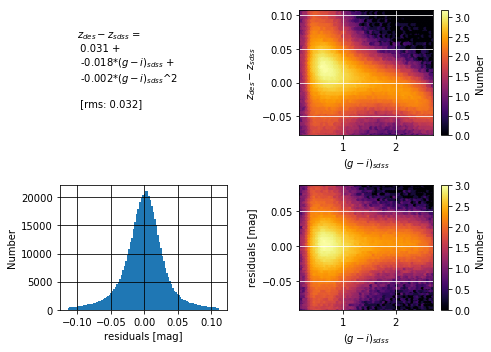

In [15]:
bandList = ['g', 'r', 'i', 'z']

for band in bandList:
    
    magName_des = """%s_des""" % (band)
    magErrName_des = """%s_err_des""" % (band)
    magName_sdss = """%s_sdss""" % (band)
    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band}_des - {$band}_sdss...
    df.loc[:,'dmag'] = df.loc[:,magName_des] - df.loc[:,magName_sdss]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = abs(df[magErrName_des]) <= 0.01
    mask = mask & mask1 & mask2

    # Iterate, with sigma-clipping...
    for i in range(niter):

        iiter = i + 1
        if verbose > 0:
            print """   iter%d...""" % ( iiter )

        # make a copy of original df, overwriting the old one...
        df = df[mask].copy()

        # Identify dmag and color1 series...
        dmag =  df.loc[:,'dmag']
        color1 = df.loc[:,color_name_1]

        # Perform fit...
        p,perr,rms = transformFit1(color1, dmag, norder, verbose)
        df.loc[:,'res'] = residuals1(p, color1, dmag)

        # Identify outliers...|
        stddev = df['res'].std()
        mask = (np.abs(df.res)< nsigma*stddev)


    
    # Create names for use in QA plots...
    #dmagName = '$g_{des} - g_{sdss}$'
    #colorName1 = '$(g-i)_{sdss}$'
    dmagName = """$%s_{des} - %s_{sdss}$""" % (band, band)
    colorName1 = '$(g-i)_{sdss}$'

    # Create QA plots...
    qaFileBaseName='plot'
    res =  df.loc[:,'res']
    outputFileName = """%s.%s.%s.qa1.png""" % (qaFileBaseName, 'uNUV', 'NUVg')
    status = transform1ColorQAPlots1(dmag, color1, res, norder, dmagName, colorName1, p, rms, outputFileName)
